- movies: movement of particles with arrows AND heat bars with colours according to direction of motion
- in header of graph: parameter display for velocity and noise
- cos(theta)/|cos(theta)| - for 1 timeframe for all particles --> should be close to 1 and plot this against time
- evaluate the behaviour of theta-stuff with time

In [1]:
#import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.cm as cm

In [2]:
#change to directory
path = "C:/Users/moniq/Dropbox/MA_1/MA_2_Physics-of-Life/project/evaluation"
os.chdir(path)

pathdata = "out_agntno_300_noistr_1.000000.txt"
time, agent_index, position_x, position_y, angles = np.loadtxt(pathdata,float,skiprows=2,unpack=True)

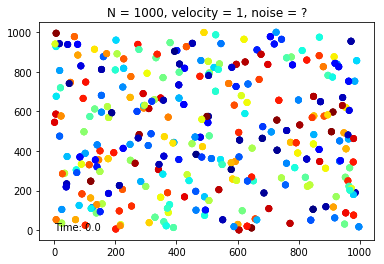

In [3]:
#further parameters
agent_number = 1000 #particle number
box_size = 100 #size of box
N = 1000  #number of particles

#movie
fig = plt.figure()
positions = plt.scatter(position_x[0:N],position_y[0:N],c=cm.jet(angles[0:N]/(2*np.pi)))
plt.title("N = {}, velocity = 1, noise = ?".format(N))
text = plt.text(0,-2,"Time: 0")

#update function for movie
def update(i,positions,text):
    #update(time, any further things which should be updated in animation)
    positions.set_offsets(np.transpose([position_x[i*N:(i+1)*N],position_y[i*N:(i+1)*N]]))
    positions.set_color(c=cm.jet(angles[i*N:(i+1)*N]/(2*np.pi)))
    text.set_text("Time: {:.1f}".format(time[i*N]))
    return positions,text

#generate a movie
animation = anim.FuncAnimation(fig,update,np.size(time)//N,fargs=(positions,text),interval=100,blit=False,repeat=False)

#for MP4 files
Writer = anim.FFMpegWriter(fps=10, bitrate=1800)
plt.rcParams["animation.ffmpeg_path"] = "C:/Users/moniq/Dropbox/MA_1/MA_2_Physics-of-Life/project/evaluation/FFmpeg/bin/ffmpeg.exe"

#save movie
animation.save("test.mp4", writer=Writer)
plt.show()